<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
!subst N: E:\Network_Data_Sync
!subst S: E:\Network_Data_Sync
!subst O: "E:\OneDrive - Washington University in St. Louis"

In [141]:
# reload the libs as we edit them
%load_ext autoreload
%autoreload 2

In [204]:
# load corr feat tsr
import numpy as np
from scipy.io import loadmat
from os.path import join
from sklearn.decomposition import NMF
import matplotlib.pylab as plt
from numpy.linalg import norm as npnorm
mat_path = r"E:\OneDrive - Washington University in St. Louis\Mat_Statistics"
def show_img(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def rectify_tsr(Ttsr, mode="abs", thr=(-5, 5)):
    if mode is "pos_rect":
        Ttsr_pp = np.clip(Ttsr, 0, None)
    elif mode is "abs":
        Ttsr_pp = np.abs(Ttsr)
    elif mode is "thresh":
        Ttsr_pp = Ttsr.copy()
        Ttsr_pp[(Ttsr<thr[1])*(Ttsr>thr[0])] = 0
        Ttsr_pp = np.abs(Ttsr_pp)
    else:
        raise ValueError
    return Ttsr_pp

In [265]:
def torch_pearsonr(x, y):
    """
    Mimics `scipy.stats.pearsonr`
    Arguments
    ---------
    x : 1D torch.Tensor
    y : 1D torch.Tensor
    Returns
    -------
    r_val : float
        pearsonr correlation coefficient between x and y
    """
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)
    xm = x.sub(mean_x)
    ym = y.sub(mean_y)
    r_num = xm.dot(ym)
    r_den = torch.norm(xm, 2) * torch.norm(ym, 2)
    r_val = r_num / r_den
    return r_val

In [215]:
Animal = "Beto"
Expi = 11
corrDict = np.load(join("S:\corrFeatTsr","%s_Exp%d_Evol_nobdr_corrTsr.npz"%(Animal,Expi)), allow_pickle=True)
cctsr_dict = corrDict.get("cctsr").item()
Ttsr_dict = corrDict.get("Ttsr").item()

In [203]:
ReprStats = loadmat(join(mat_path, Animal + "_ImageRepr.mat"), struct_as_record=False, squeeze_me=True, chars_as_strings=True)['ReprStats']

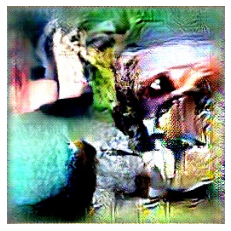

In [212]:
show_img(ReprStats[Expi].Manif.BestImg)

NMF explained variance 0.429


C:\Users\binxu\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


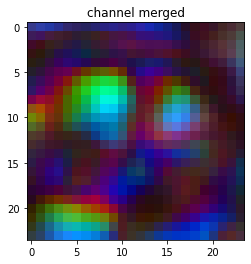

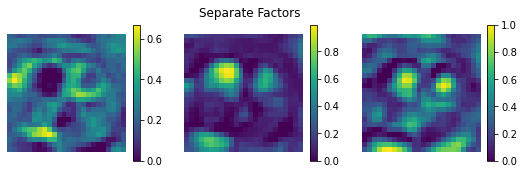

In [245]:
mode = "abs"#"thresh"#pos_rect
thr = (-4,4)
layer = "conv4_3"
bdr = 2
Ttsr = Ttsr_dict[layer]
cctsr = cctsr_dict[layer]
Ttsr_pp = rectify_tsr(Ttsr, mode="thresh", thr=thr)
C, H, W = Ttsr_pp.shape
if bdr == 0:
    Tmat = Ttsr_pp.reshape(C, H*W)
    ccmat = cctsr.reshape(C, H*W)
else:
    Tmat = Ttsr_pp[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
    ccmat = cctsr[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
#%
nmfsolver = NMF(n_components=3, init="nndsvda", solver="cd")#mu
Hmat = nmfsolver.fit_transform(Tmat.T)
Hmaps = Hmat.reshape([H-2*bdr, W-2*bdr, 3])
exp_var = 1-npnorm(Tmat.T-Hmat@nmfsolver.components_)/npnorm(Tmat)
print("NMF explained variance %.3f"%exp_var)
plt.imshow(Hmaps / Hmaps.max())
plt.title("channel merged")
plt.show()
[figh, axs] = plt.subplots(1,3,figsize=[9, 2.5])
for ci in range(Hmaps.shape[2]):
    plt.sca(axs[ci])
    plt.imshow(Hmaps[:,:,ci] / Hmaps.max())
    plt.axis("off")
    plt.colorbar()
plt.suptitle("Separate Factors")
plt.show()

ccfactor = (ccmat @ np.linalg.pinv(Hmat).T )
# ccfactor = (ccmat @ Hmat )
np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]

array([[ 9.233795 ,  9.718565 ,  7.9461827, ..., 10.994765 , 10.000463 ,
         9.229468 ],
       [ 8.552366 ,  8.686569 ,  7.245175 , ..., 10.030194 ,  9.284431 ,
         8.728769 ],
       [ 8.084076 ,  7.845777 ,  6.5208244, ...,  9.131856 ,  9.128148 ,
         8.665923 ],
       ...,
       [ 7.1597385, 12.680461 ,  5.826672 , ...,  9.084945 , 11.098207 ,
         6.541621 ],
       [ 7.5513954, 11.712881 ,  6.2439976, ...,  9.392826 , 10.641441 ,
         7.1079817],
       [ 7.1202674,  8.523932 ,  5.6944556, ...,  8.268019 ,  8.99465  ,
         7.3807116]], dtype=float32)

In [191]:
featvecs = nmfsolver.components_
fact_norms = []
for i in range(Hmaps.shape[2]):
    rank1_mat = Hmat[:, i:i+1]@featvecs[i:i+1, :]
    matnorm = npnorm(rank1_mat, ord="fro")
    fact_norms.append(matnorm)
    print("Factor%d norm %.2f"%(i, matnorm))

Factor0 norm 1331.94
Factor1 norm 2132.58
Factor2 norm 1866.22


0.5200259978977041

Now let's load up the network and Generator, visualize the contents for this neuron group / feature vector

In [279]:
from CorrFeatTsr_visualize import CorrFeatScore, corr_GAN_visualize, preprocess

In [ ]:
from GAN_utils import upconvGAN
import torch
from torchvision import models
VGG = models.vgg16(pretrained=True)
VGG.requires_grad_(False)
VGG.features.cuda()
G = upconvGAN("fc6").cuda()
G.requires_grad_(False)

Visualize the feature vector without spatial structure, (full feature map)

step 99, score 3.67 4.30 5.61 7.84: 100%|██████████| 100/100 [00:09<00:00, 10.36it/s]   


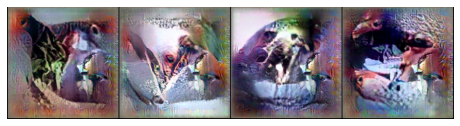

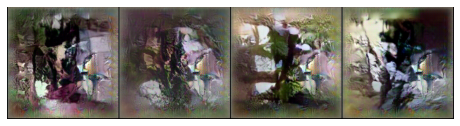

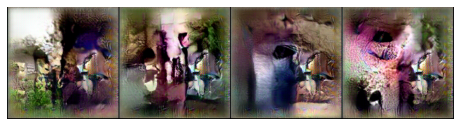

In [228]:
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
for ci in [0, 1, 2]:
    fact_W = torch.from_numpy(ccfactor[:, ci]).reshape([-1,1,1])
    scorer.register_weights({layer: fact_W})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.025, MAXSTEP=100, imshow=True, verbose=False, adam=True)
scorer.clear_hook()

Visualize the feature vector times the spatial mask from regressing the correlation tensor, (structured feature map)

Feature Correlator Destructed, Hooks deleted.


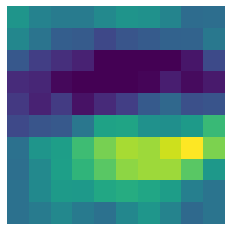

step 99, score 0.01 0.04 0.09 0.02: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]   


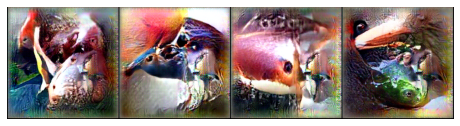

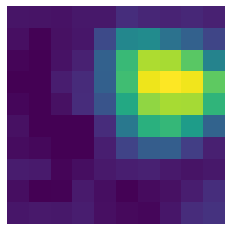

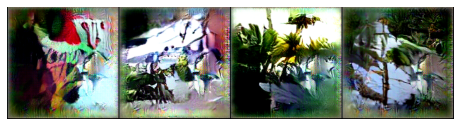

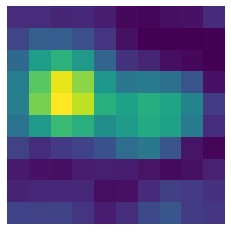

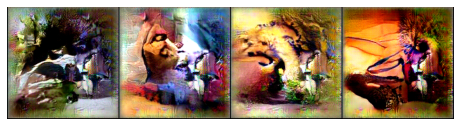

In [231]:
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
for ci in [0, 1, 2]:
    padded_mask = np.pad(Hmaps[:,:,ci:ci+1], ((bdr,bdr),(bdr,bdr),(0,0)))
    fact_Wtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, ci:ci+1], padded_mask))
    show_img(Hmaps[:,:,ci:ci+1])
    scorer.register_weights({layer: fact_Wtsr})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.1, MAXSTEP=100, imshow=True, verbose=False)
scorer.clear_hook()

Visualize the feature vector at the center of the feature map, (structured feature map)

step 99, score 0.06 0.44 0.16 0.27: 100%|██████████| 100/100 [00:10<00:00,  9.76it/s] 


Feature Correlator Destructed, Hooks deleted.


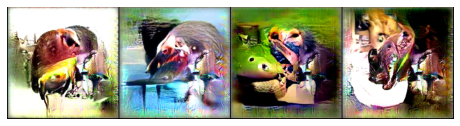

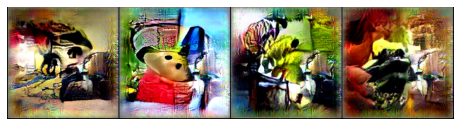

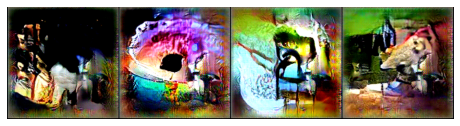

In [232]:
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
for ci in [0, 1, 2]:
    H,W,_ = Hmaps.shape
    sp_mask = np.pad(np.ones([2,2,1]), ((H//2-1+bdr,H-H//2-1+bdr),(W//2-1+bdr, W-W//2-1+bdr),(0,0)))
    fact_Chtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, ci:ci+1], sp_mask))
    scorer.register_weights({layer: fact_Chtsr})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.10, MAXSTEP=100, imshow=True, verbose=False)
scorer.clear_hook()

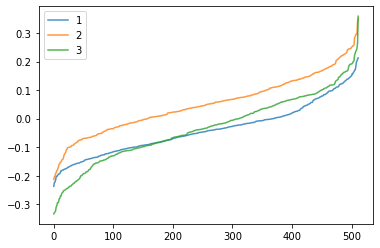

In [111]:
plt.plot(np.sort(ccfactor,axis=0), alpha=0.8)
plt.legend([1,2,3])
plt.show()

In [105]:
# Use pseudo inverse to compute the regression factors along the channel dimension.
np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]

0.7044371898945597

In [54]:
npnorm(featvecs, axis=1)
npnorm(Hmat, axis=0)

array([113.21262 , 124.157684, 111.78014 ], dtype=float32)

step 99, score 0.23 0.39 0.28 0.32 0.29: 100%|██████████| 100/100 [00:10<00:00,  9.15it/s]    


Feature Correlator Destructed, Hooks deleted.
Final scores 0.39 0.32 0.29 0.28 0.23


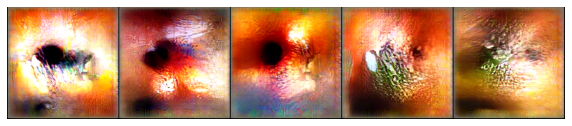

In [261]:
padded_mask = np.pad(Hmaps[:,:,:], ((bdr,bdr),(bdr,bdr),(0,0)))
DR_Wtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, :], padded_mask))
DR_Wtsr.shape
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
scorer.register_weights({layer: 10*DR_Wtsr}) #
finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.05, MAXSTEP=100, imshow=True, verbose=False, langevin_eps=0, Bsize=5)
scorer.clear_hook()

In [235]:
from data_loader import load_score_mat, loadmat, mat_path
from CorrFeatTsr_lib import visualize_cctsr, visualize_cctsr_embed, Corr_Feat_Machine, Corr_Feat_pipeline, loadimg_preprocess, loadimg_embed_preprocess
from tqdm import tqdm

In [270]:
MStats = loadmat(join(mat_path, Animal + "_Manif_stats.mat"), struct_as_record=False, squeeze_me=True)['Stats']
EStats = loadmat(join(mat_path, Animal + "_Evol_stats.mat"), struct_as_record=False, squeeze_me=True, chars_as_strings=True)['EStats']
score_vect, imgfullpath_vect = load_score_mat(EStats, MStats, Expi, "Manif_avg", wdws=[(50, 200)], stimdrive="S")

In [300]:
def score_images(featNet, scorer, layername, imgfps, imgloader=loadimg_preprocess, batchsize=40,):
    imgN = len(imgfps)
    csr = 0
    pbar = tqdm(total=imgN)
    score_all = []
    while csr < imgN:
        cend = min(csr + batchsize, imgN)
        input_tsr = imgloader(imgfps[csr:cend], borderblur=True)  # imgpix=120, fullimgsz=224
        with torch.no_grad():
            part_tsr = featNet(input_tsr.cuda()).cpu()
            score = scorer.corrfeat_score(layername)
        score_all.append(score.detach().clone().cpu())
        pbar.update(cend - csr)
        csr = cend
    pbar.close()
    score_all = torch.cat(tuple(score_all), dim=0)
    return score_all

scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
scorer.register_weights({layer: 10*DR_Wtsr.unsqueeze(0)})
pred_score = score_images(VGG.features, scorer, layer, imgfullpath_vect, imgloader=loadimg_preprocess, batchsize=40,)
scorer.clear_hook()

E:\Github_Projects\Visual_Neuron_Modelling\CorrFeatTsr_visualize.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight_tsr[layer] = torch.tensor(weight).float().cuda()
100%|██████████| 121/121 [00:02<00:00, 58.12it/s]


torch.Size([121])

In [295]:
input_tsr = loadimg_preprocess(imgfullpath_vect[:30], borderblur=True)
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
scorer.register_weights({layer: 10*DR_Wtsr.unsqueeze(0)})
VGG.features(input_tsr.cuda()).cpu()
score = scorer.corrfeat_score(layers=layer)

E:\Github_Projects\Visual_Neuron_Modelling\CorrFeatTsr_visualize.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight_tsr[layer] = torch.tensor(weight).float().cuda()


torch.Size([30])

In [288]:
DR_Wtsr.shape

torch.Size([512, 28, 28])

In [303]:
np.corrcoef(score_vect, pred_score.numpy())[0, 1]

0.8496500967486587

In [304]:
del scorer
# reshape to channel by space

# NMF factorize

# Reshape spatial factors

# Normalize spatial factors

# visualize plot 3 channel plot